Meraj Patel

In [1]:
import numpy as np
import seaborn as sns; sns.set(style="ticks", color_codes=True) 
import sklearn.datasets as datasets
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Import dataset
dataset = pd.read_csv("synthetic_clustering_dataset.csv")

dataset.head()

,f1,f2
0,0.494261,1.451067
1,-1.428081,-0.837064
2,0.338559,1.038759
3,0.119001,-1.053976
4,1.122425,1.774937


### Data Overview

In [2]:
dataset.shape

(750, 2)

In [3]:
dataset.isna().sum()

f1    0
f2    0
dtype: int64

In [4]:
dataset.dtypes

f1    float64
f2    float64
dtype: object

In [5]:
dataset.describe()

,f1,f2
count,7.500000e+02,7.500000e+02
mean,5.222933e-15,-7.853925e-14
std,1.000667e+00,1.000667e+00
min,-2.274474e+00,-1.823801e+00
25%,-1.091894e+00,-7.775487e-01
50%,3.886712e-01,-4.095144e-01
75%,7.787849e-01,1.052538e+00
max,1.870438e+00,2.245794e+00


<AxesSubplot:xlabel='f1', ylabel='f2'>

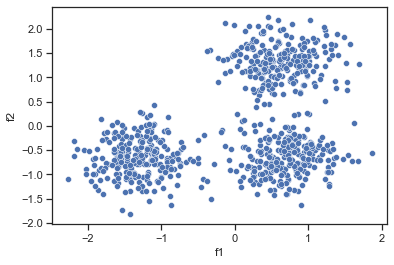

In [6]:
sns.scatterplot(x = 'f1', y='f2', data=dataset)

As shown in the plot, we can see three clusters of points, thus implying __three species__ in the dataset. 

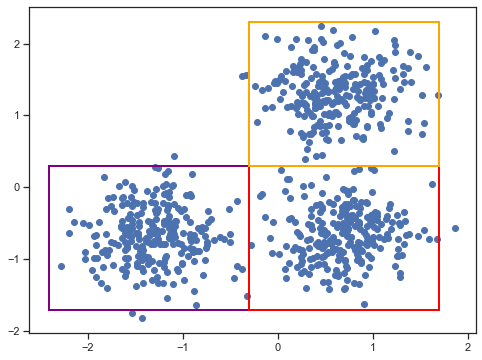

In [7]:
import matplotlib.patches as mpatches
plt.figure(figsize=(8,6))
plt.scatter(x=dataset.f1, y=dataset.f2)

# Species One
left, bottom, width, height = (-2.4, -1.7, 2.1, 2)
s_1=mpatches.Rectangle((left,bottom),width,height, 
                        fill=False,
                        color="purple",
                       linewidth=2)

# Species Two
left, bottom, width, height = (-0.3, -1.7, 2, 2)
s_2=mpatches.Rectangle((left,bottom),width,height, 
                        fill=False,
                        color="red",
                       linewidth=2)

# Species Two
left, bottom, width, height = (-0.3, 0.3, 2, 2)
s_3=mpatches.Rectangle((left,bottom),width,height, 
                        fill=False,
                        color="orange",
                       linewidth=2)

plt.gca().add_patch(s_1)
plt.gca().add_patch(s_2)
plt.gca().add_patch(s_3)
plt.show()

Rectangular annotations above reflect feature ranges per species. 

## K-means clustering 

In [8]:
# Apply Standard Scaler
ss = StandardScaler()
df_km = pd.DataFrame(ss.fit_transform(dataset), columns =['f1', 'f2'])

In [9]:
# Apply KMeans with cluster = 3
model_km = KMeans(n_clusters=3)
model_km.fit(df_km)

KMeans(n_clusters=3)

In [10]:
# Calculate distance to centroid per point
def distance_to_centroid(x, y, label):
    cen_x = model_km.cluster_centers_[label,0]
    cen_y = model_km.cluster_centers_[label,1]
    distance = np.sqrt((x - cen_x)**2 + (y - cen_y)**2)
    return np.round(distance, 3)
    
df_km['label'] = model_km.labels_
df_km['distance'] = distance_to_centroid(df_km.f1, df_km.f2, df_km.label)

# Select outliers - 20 points based on furthest distance from centroid
outliers_idx = df_km['distance'].sort_values(ascending=False).head(20).index
outliers_km = df_km[df_km.index.isin(outliers_idx)]

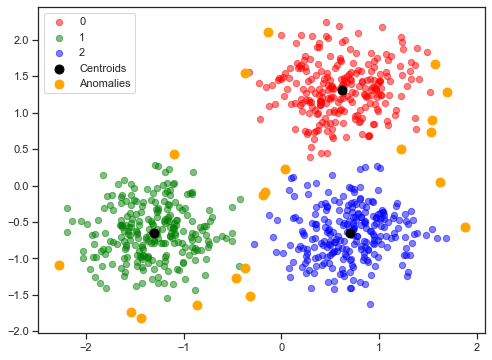

In [11]:
colors = ['red', 'green', 'blue']
plt.figure(figsize=(8,6))

# Plot points in color refelcting cluster
for i in range(3):
    plt.scatter(df_km[model_km.labels_==i].f1 , df_km[model_km.labels_==i].f2, label = i, c=colors[i], alpha=0.5, s=40)

# Highlight Centroids in black
plt.scatter(model_km.cluster_centers_[:,0], model_km.cluster_centers_[:,1], label='Centroids', c="black", s=80)

# Highlight anomalies in orange
plt.scatter(outliers_km.f1, outliers_km.f2, label='Anomalies', c='orange', s=80)

plt.legend()
plt.show()

The plot above exhibits points distinguished into clusters discovered via the Kmeans algorithm. Additionally, anomalies (20 points) are highlighted in orange. Said points are marked as anomalies since they are the furthest distance from their associated centroid. 

# DBSCAN

In [12]:
# Apply Standard Scaler
ss = StandardScaler()
df_db = pd.DataFrame(ss.fit_transform(dataset), columns =['f1', 'f2'])

In [13]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN 
model_db = DBSCAN(eps=0.2, min_samples=5)
model_db.fit(df_db)

# Select outliers
outliers_db = df_db[model_db.labels_ == -1]

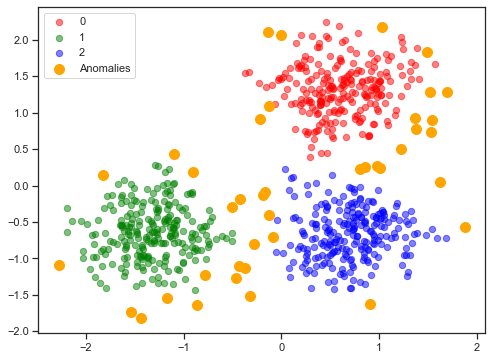

In [14]:
colors = ['red', 'green', 'blue']
plt.figure(figsize=(8,6))
for i in range(3):
    plt.scatter(df_db[model_db.labels_==i].f1 , df_db[model_db.labels_==i].f2, label = i, c=colors[i], alpha=0.5, s=40)

# Highlight outliers in orange
plt.scatter(outliers_db.f1, outliers_db.f2, label='Anomalies', c='orange', s=100)
plt.legend()
plt.show()

The plot above exhibits points distinguished into clusters discovered via the DBSCAN algorithm. Additionally, anomalies are highlighted in orange.

## DT with outliers


In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree

def evaluate_model(_model, _X, _y):
    accs = []
    kf = StratifiedKFold(n_splits=10, shuffle=False)
    for train_idx, test_idx in kf.split(_X, _y):
        model = _model.fit(_X[train_idx], _y[train_idx])
        y_pred = model.predict(_X[test_idx])
        accs.append(accuracy_score(_y[test_idx], y_pred))
    return accs, model

In [16]:
df_km.drop(columns=['distance'], inplace=True)
X = np.array(df_km.drop(columns=['label']))
y = np.array(df_km['label'])
accs, model_dt = evaluate_model(DecisionTreeClassifier(), X, y)
print(f' DecisionTree (with outliers) Stratified 10-fold CV acc={np.mean(accs):.3f}')

 DecisionTree (with outliers) Stratified 10-fold CV acc=0.996


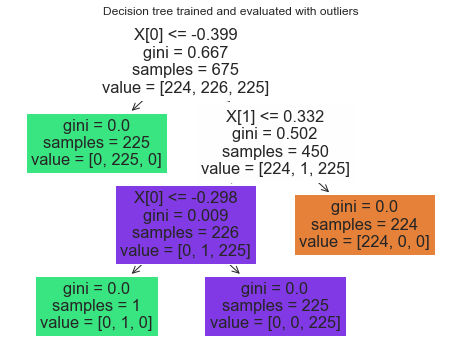

In [17]:
plt.figure(figsize=(8,6))
plot_tree(model_dt, filled=True)
plt.title("Decision tree trained and evaluated with outliers")
plt.show()

The above reflects utilizing a decision tree for classifying our dataset (with outliers) to predict species labels as discovered via the KMeans algorithm (Q3).

## DT w/o outliters

In [18]:
# Remove Outliers
df_km.drop(outliers_km.index, axis=0, inplace=True)

X = np.array(df_km.drop(columns=['label']))
y = np.array(df_km['label'])

accs, model_dt = evaluate_model(DecisionTreeClassifier(), X, y)
print(f' DecisionTree (w/o outliers) Stratified 10-fold CV acc={np.mean(accs):.3f}')

 DecisionTree (w/o outliers) Stratified 10-fold CV acc=1.000


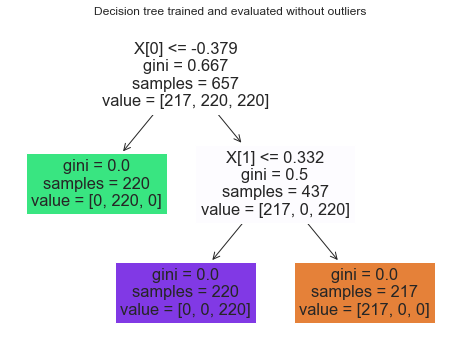

In [19]:
plt.figure(figsize=(8,6))
plot_tree(model_dt, filled=True)
plt.title("Decision tree trained and evaluated without outliers")
plt.show()

__Explanation__

As shown above, Stratified 10-fold CV yields 99.6% upon validation with outliers, while the same test yields 100% without outliers. Additionally, viewing decision tree diagrams shows fewer splits upon training without outliers than training with outliers. Specifically, the constructed decision tree training with outliers is overfitted relative to the decision tree without outliers.